Importing all necessary libraries

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel # For BERT
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Model
from sklearn.metrics import classification_report, confusion_matrix

Loading Model

In [2]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = TFBertModel.from_pretrained("bert-base-uncased", from_pt=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.

Loading dataset
Dataset Link: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [3]:
df = pd.read_csv("spam.csv", encoding="latin1")
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)
df["v1"] = df["v1"].map({"ham": 0, "spam": 1})
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
print("Total entries in dataset: ", df.shape[0])
print("Number of spam emails: ", len(df[df["v1"] == 1]))
print("Number of not spam emails: ", len(df[df["v1"] == 0]))

Total entries in dataset:  5572
Number of spam emails:  747
Number of not spam emails:  4825


Getting BERT embeddings for input 'X'

In [4]:
def get_bert_embeddings(texts, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        encoded = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="tf"
        )
        outputs = model(encoded)
        cls_embed = outputs.last_hidden_state[:, 0, :]  # CLS
        all_embeddings.append(cls_embed.numpy())
    return np.concatenate(all_embeddings, axis=0)


sentences = df["v2"].astype(str).tolist()
embeddings = get_bert_embeddings(sentences, batch_size=16)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Getting 'y' (for prediction)

In [6]:
labels = df["v1"].values

Train, test spliting them for training and testing of the model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    sentences, labels, test_size=0.2, random_state=42
)

Getting embeddings on train data

In [13]:
X_train = get_bert_embeddings(X_train, batch_size=16)
X_test = get_bert_embeddings(X_test, batch_size=16)

print("Train embeddings shape:", X_train.shape)
print("Test embeddings shape:", X_test.shape)

Train embeddings shape: (4457, 768)
Test embeddings shape: (1115, 768)


Model Logistic regression (Training)

In [14]:
reg_model = LogisticRegression().fit(X_train, y_train)

Prediction

In [15]:
pred = reg_model.predict(X_test)

Classification report (accuracy 99 percent)

In [16]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       965
           1       0.98      0.95      0.97       150

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



Confusion matrix using seaborn for better representation

<Axes: >

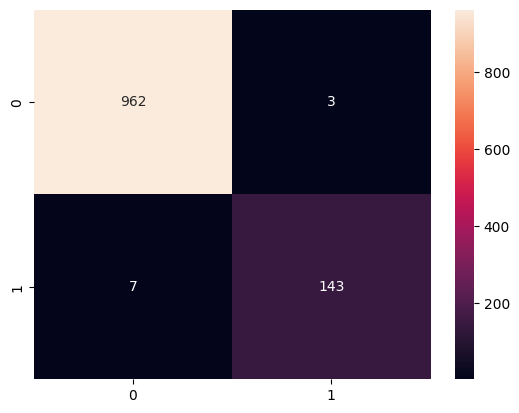

In [18]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')